# Pilot Analyses -- Psifr Edition

## Setup

In [3]:
#%% Dependencies

from experiments.category_targeting.helpers import export_to_psifr_long_table, load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
    }

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )

    return pd.DataFrame.from_dict(events)

In [ ]:
# %% Load data
embam_data_path = "experiments/category_targeting/expt2.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)
events.head()

,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category
0,0,1,study,1,467,2,True,16,20,27
1,0,1,study,2,221,2,True,16,20,13
2,0,1,study,3,131,2,True,16,20,8
3,0,1,study,4,286,2,True,16,20,16
4,0,1,study,5,34,2,True,16,20,2


In [6]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=['condition', 'target_success', 'listLength', 'trial_category_cue', 'category']
)
data.head()


,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,prior_list,prior_input
0,0,1,34,5,3.0,True,True,0,False,2,True,16,20,2,NaN,NaN
1,0,1,126,14,NaN,True,False,0,False,2,True,16,20,7,NaN,NaN
2,0,1,131,3,NaN,True,False,0,False,2,True,16,20,8,NaN,NaN
3,0,1,168,16,NaN,True,False,0,False,2,True,16,20,10,NaN,NaN
4,0,1,200,6,4.0,True,True,0,False,2,True,16,20,11,NaN,NaN


## Demo Analyses

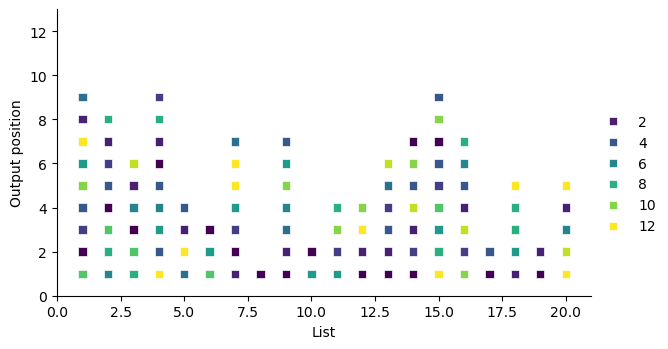

In [4]:
# %% Raster Plot
subj = fr.filter_data(data, 1)
g = fr.plot_raster(subj).add_legend()

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.625,5,8,control
1,0,1,2,0.000,0,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.000,0,8,control
4,0,1,5,0.000,0,8,control
...,...,...,...,...,...,...,...
3019,22,12,8,NaN,0,0,failure
3020,22,12,9,NaN,0,0,failure
3021,22,12,10,NaN,0,0,failure
3022,22,12,11,NaN,0,0,failure


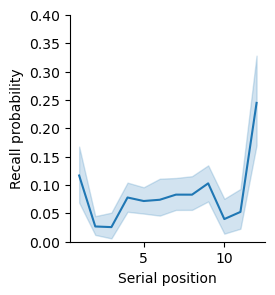

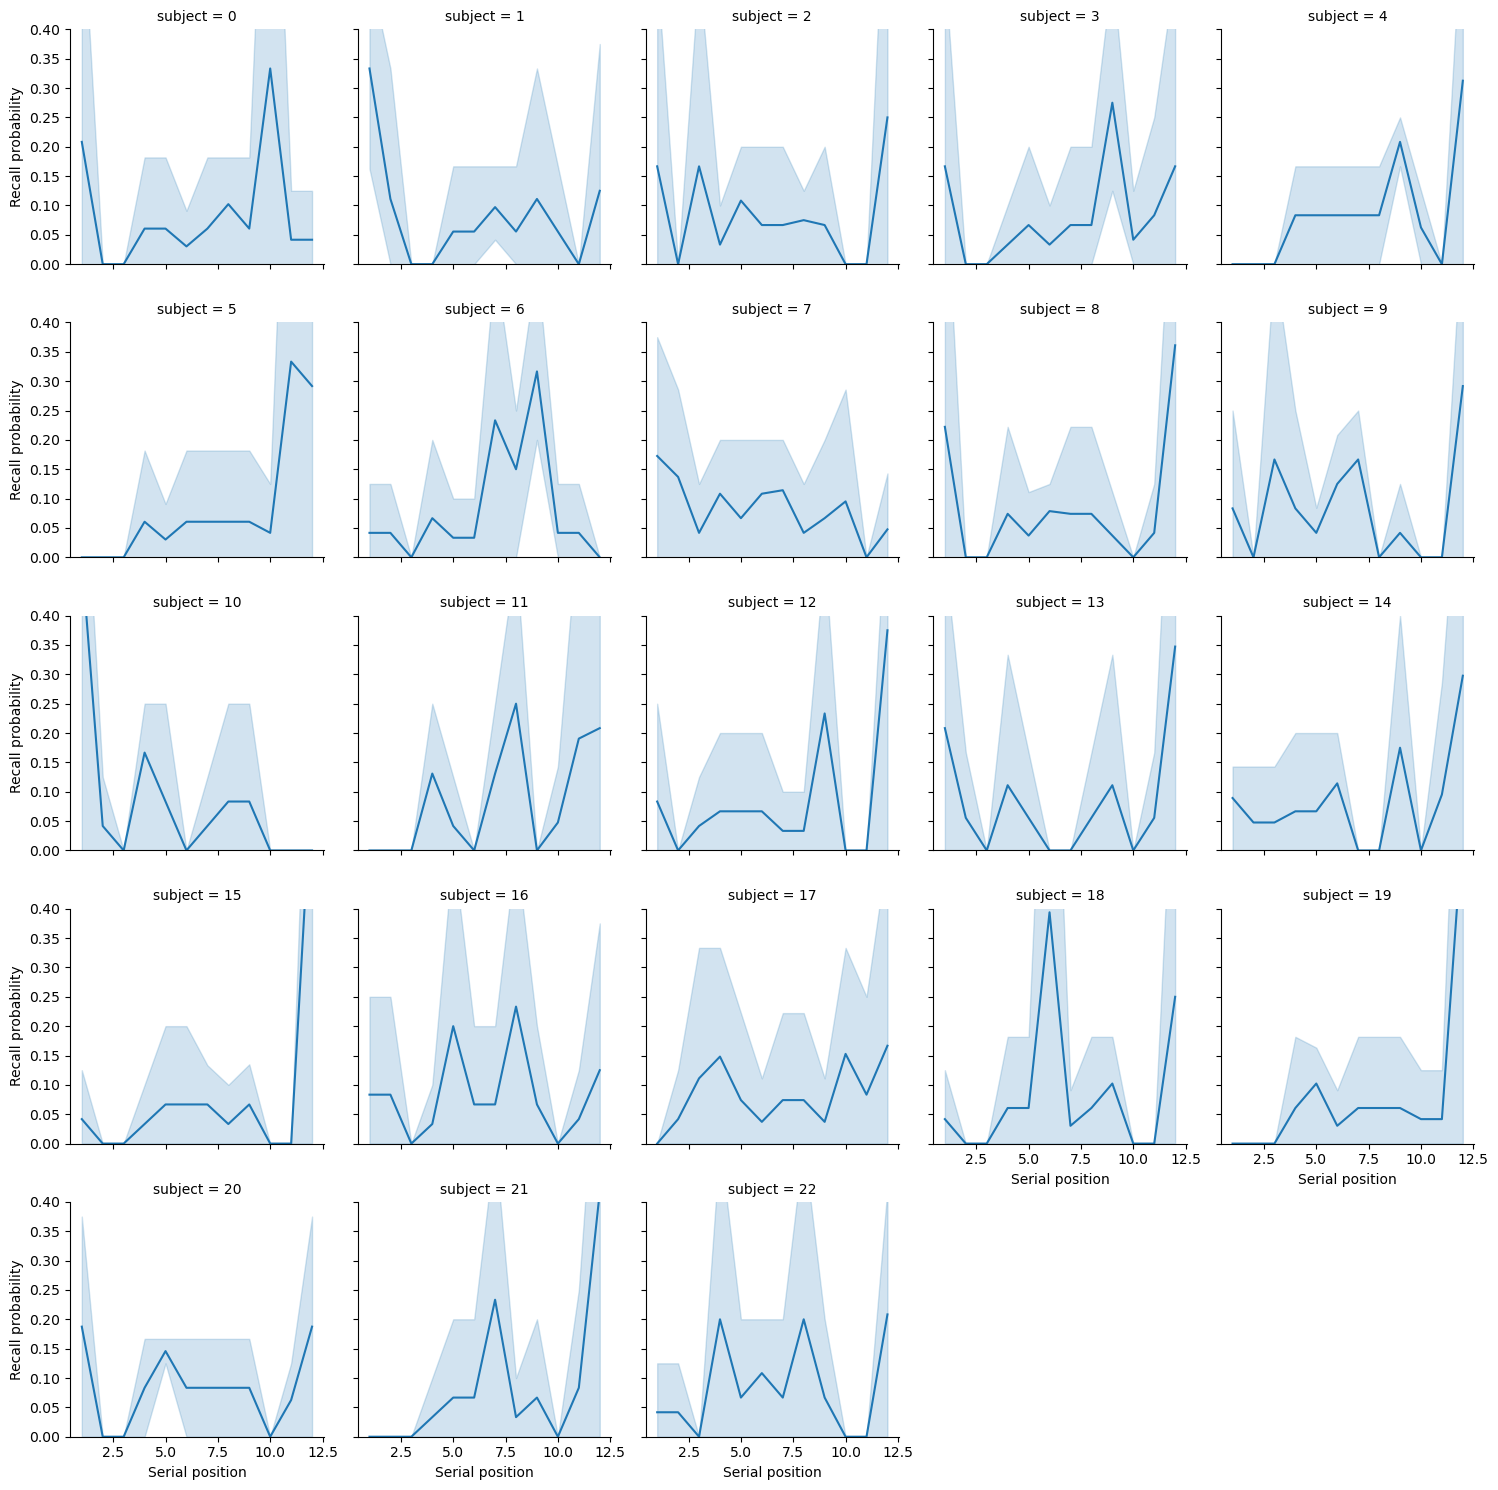

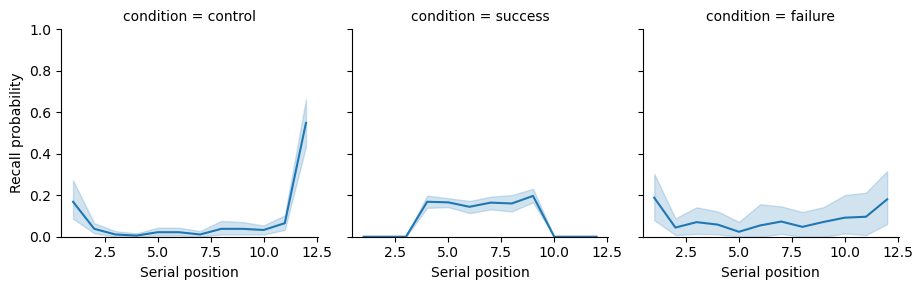

In [5]:
# %% PFR

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output <= 1')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.625,5,8,control
1,0,1,2,0.000,0,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.000,0,8,control
4,0,1,5,0.000,0,8,control
...,...,...,...,...,...,...,...
3019,22,12,8,NaN,0,0,failure
3020,22,12,9,NaN,0,0,failure
3021,22,12,10,NaN,0,0,failure
3022,22,12,11,NaN,0,0,failure


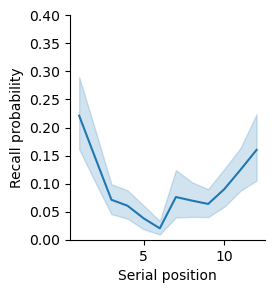

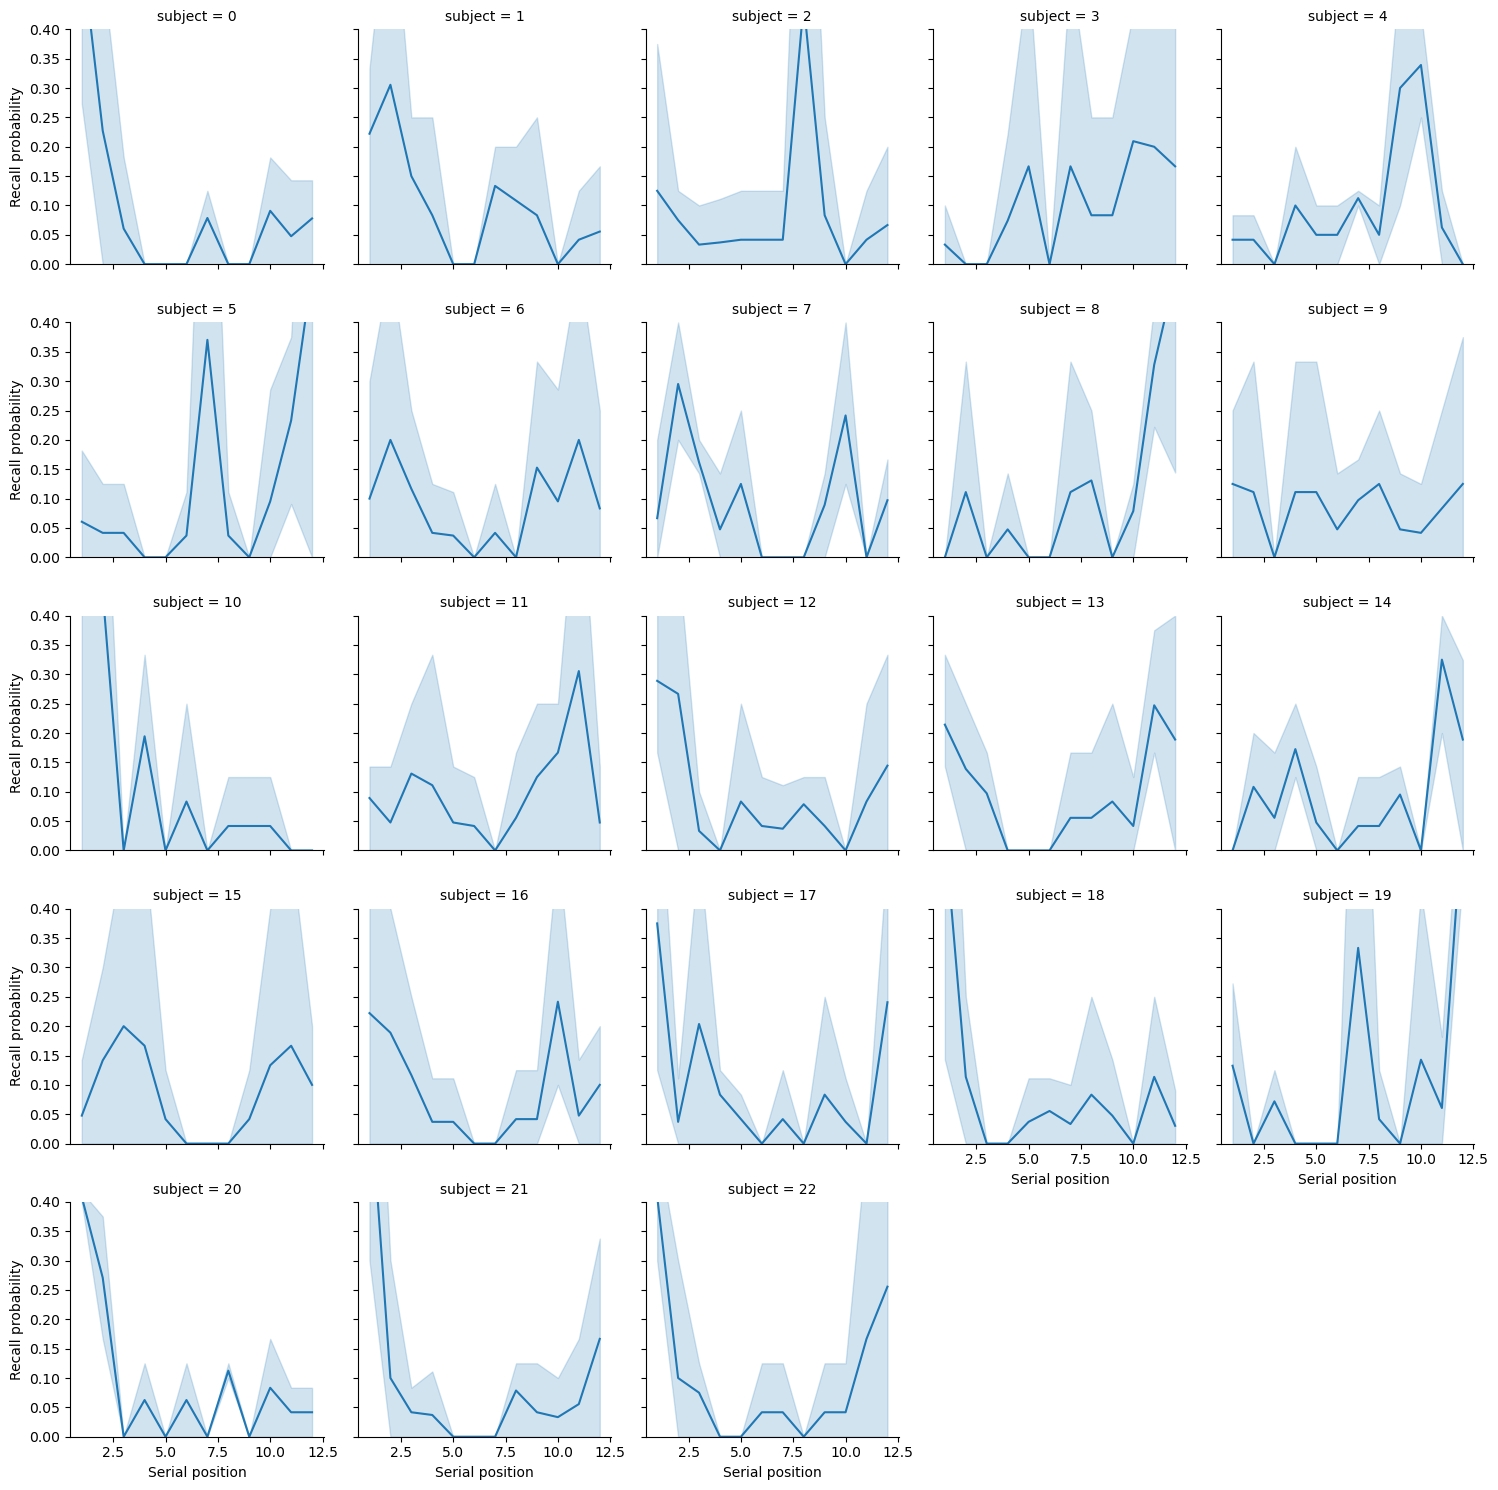

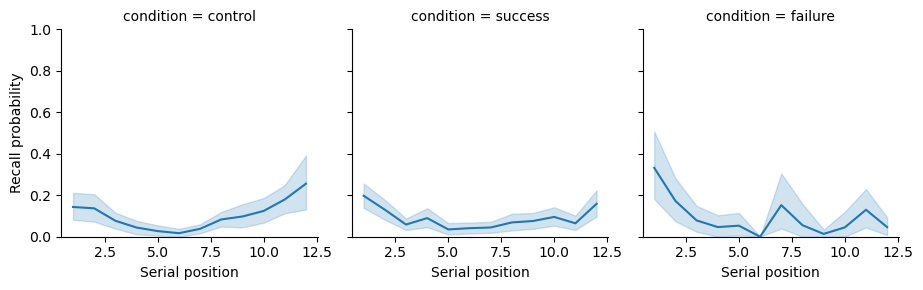

In [6]:
# %% P2R

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output == 2')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

,subject,lag,prob,actual,possible,condition
0,0,-11,0.000000,0,2,control
1,0,-10,0.000000,0,4,control
2,0,-9,0.166667,1,6,control
3,0,-8,0.000000,0,7,control
4,0,-7,0.166667,2,12,control
...,...,...,...,...,...,...
478,22,7,0.250000,1,4,failure
479,22,8,0.166667,1,6,failure
480,22,9,0.000000,0,4,failure
481,22,10,0.000000,0,2,failure


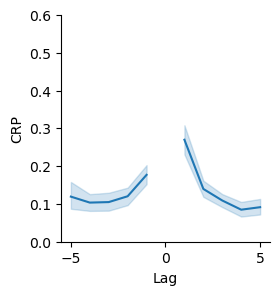

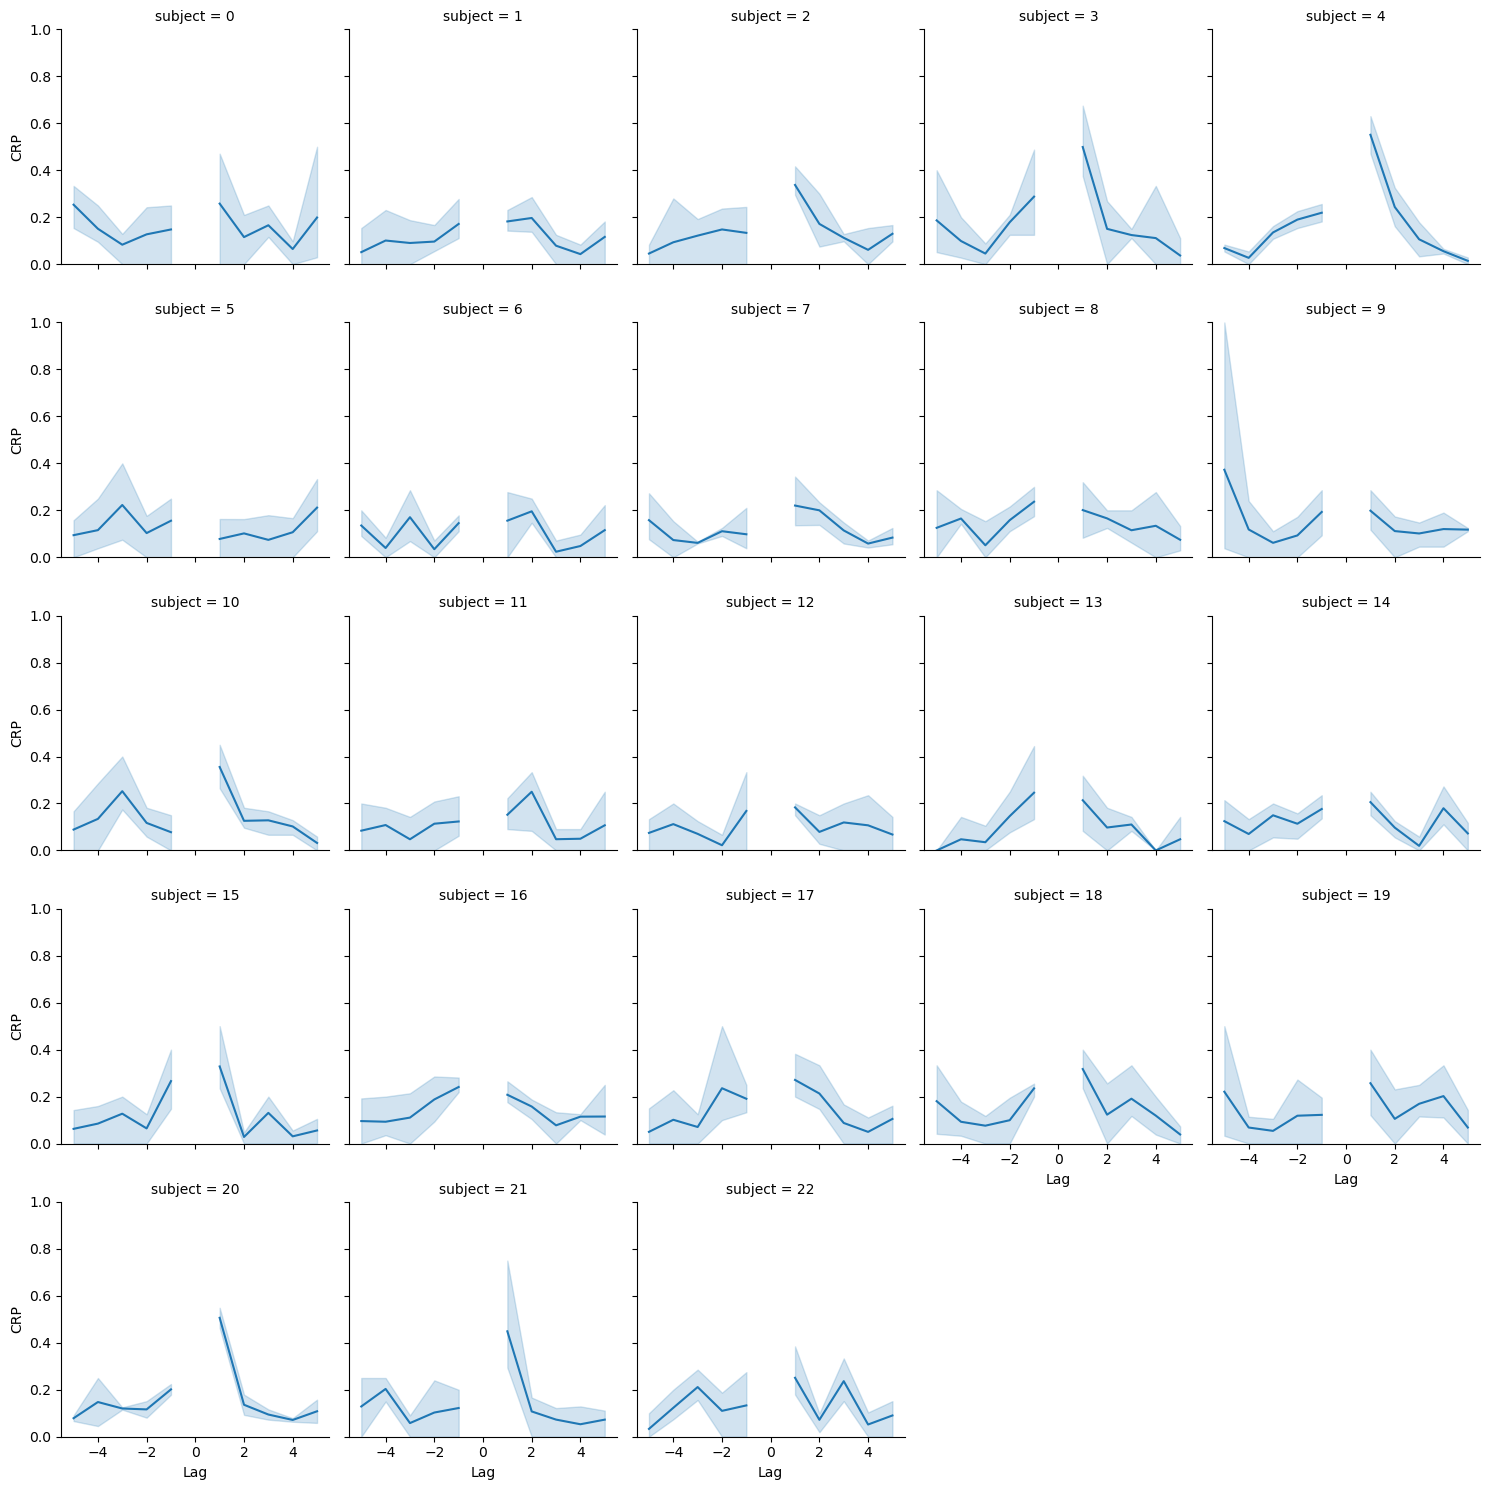

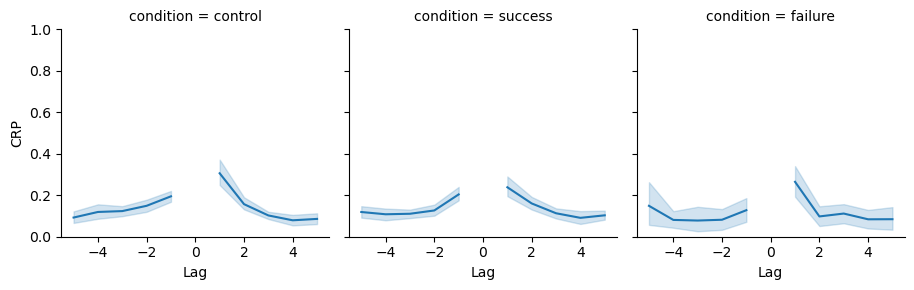

In [7]:
# %% Lag-CRP

crp_control = fr.lag_crp(data.query('condition == 0'))
crp_success = fr.lag_crp(data.query('condition == 2'))
crp_attempt = fr.lag_crp(data.query('condition == 1'))
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# lag_crp = fr.lag_crp(data)
g = fr.plot_lag_crp(lag_crp)
plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='subject', col_wrap=5)
#plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [8]:
# %% Lag-Rank Analysis
ranks_control = fr.lag_rank(data.query('condition == 0'))
ranks_success = fr.lag_rank(data.query('condition == 2'))
ranks_attempt = fr.lag_rank(data.query('condition == 1'))
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])
ranks

control
mean    0.604777
sem     0.013934
Name: rank, dtype: float64
success
mean    0.577579
sem     0.017815
Name: rank, dtype: float64
failure
mean    0.565450
sem     0.026559
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.650929,control
1,1,0.597586,control
2,2,0.610108,control
3,3,0.761175,control
4,4,0.746043,control
...,...,...,...
16,17,0.749206,failure
17,18,0.605208,failure
18,19,0.554167,failure
19,21,0.676290,failure


## How Often Do Subjects Recall the Category Target?

In [9]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query('condition > 0').pivot_table(
    index='subject', values='target_success', aggfunc='mean')

# mean and sem over subjects
print(success_rates.agg(['mean', 'sem'])['target_success'])
success_rates

mean    0.755376
sem     0.040560
Name: target_success, dtype: float64


,target_success
subject,
0,0.914474
1,0.496599
2,0.834483
3,0.843750
4,1.000000
5,0.913580
6,0.836735
7,0.417808
8,0.746575


## Focusing on Transitions From Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-11,NaN,0,0,control
1,0,-10,NaN,0,0,control
2,0,-9,NaN,0,0,control
3,0,-8,NaN,0,0,control
4,0,-7,1.0,1,1,control
...,...,...,...,...,...,...
478,22,7,0.0,0,1,failure
479,22,8,NaN,0,0,failure
480,22,9,NaN,0,0,failure
481,22,10,NaN,0,0,failure


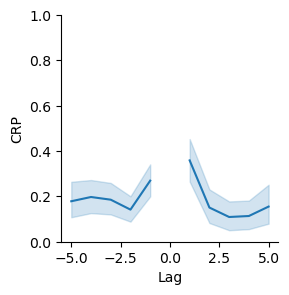

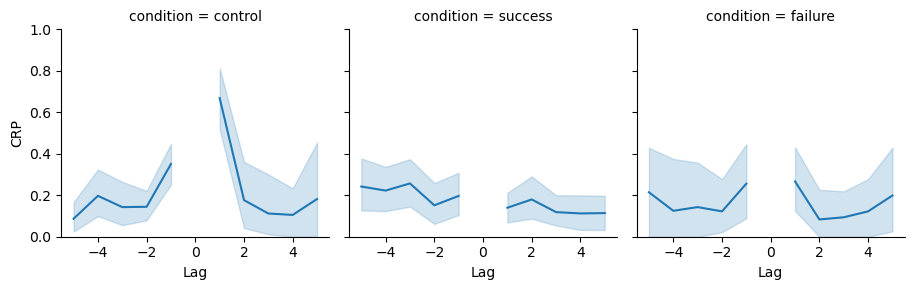

In [10]:
# %% First Transition Lag-CRP
crp_control = fr.lag_crp(data.query('condition == 0'), item_query='output < 3 or not recall')
crp_success = fr.lag_crp(data.query('condition == 2'), item_query='output < 3 or not recall')
crp_attempt = fr.lag_crp(data.query('condition == 1'), item_query='output < 3 or not recall')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

,subject,lag,prob,actual,possible,condition
0,0,-11,NaN,0,0,control
1,0,-10,NaN,0,0,control
2,0,-9,NaN,0,0,control
3,0,-8,NaN,0,0,control
4,0,-7,NaN,0,0,control
...,...,...,...,...,...,...
478,22,7,NaN,0,0,failure
479,22,8,NaN,0,0,failure
480,22,9,NaN,0,0,failure
481,22,10,NaN,0,0,failure


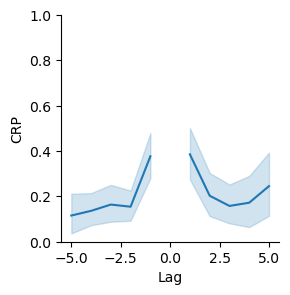

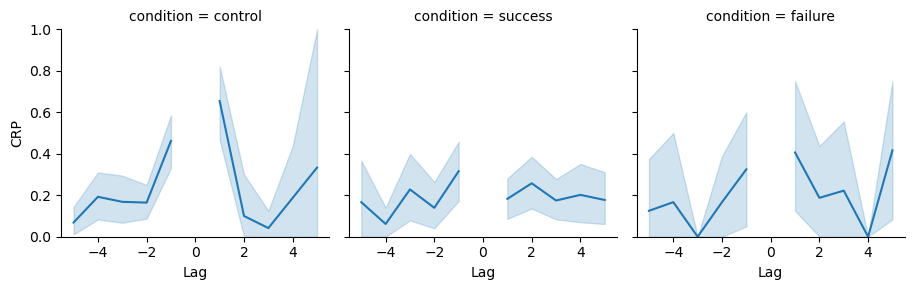

In [19]:
#! code-summary: added query to exclude transitiosn to first item in the list in our condition==2

crp_control = fr.lag_crp(data.query('condition == 0'),  item_query='(output < 3 or not recall) and input > 2')
crp_success = fr.lag_crp(data.query('condition == 2'),  item_query='(output < 3 or not recall) and input > 2')
crp_attempt = fr.lag_crp(data.query('condition == 1'),  item_query='(output < 3 or not recall) and input > 2')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [12]:
# %% First Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), item_query='output < 3 or not recall')
ranks_success = fr.lag_rank(data.query('condition == 2'), item_query='output < 3 or not recall')
ranks_attempt = fr.lag_rank(data.query('condition == 1'), item_query='output < 3 or not recall')

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.660253
sem     0.038300
Name: rank, dtype: float64
success
mean    0.405037
sem     0.031157
Name: rank, dtype: float64
failure
mean    0.509639
sem     0.069274
Name: rank, dtype: float64


,subject,rank
0,0,0.570833
1,1,0.373148
2,2,0.615000
3,3,0.562500
4,4,0.755417
5,5,0.252706
6,6,0.366667
7,7,0.616667
8,8,0.377778
9,9,0.269940


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-11,NaN,0,0,control
1,0,-10,NaN,0,0,control
2,0,-9,NaN,0,0,control
3,0,-8,NaN,0,0,control
4,0,-7,NaN,0,0,control
...,...,...,...,...,...,...
478,22,7,NaN,0,0,failure
479,22,8,NaN,0,0,failure
480,22,9,NaN,0,0,failure
481,22,10,NaN,0,0,failure


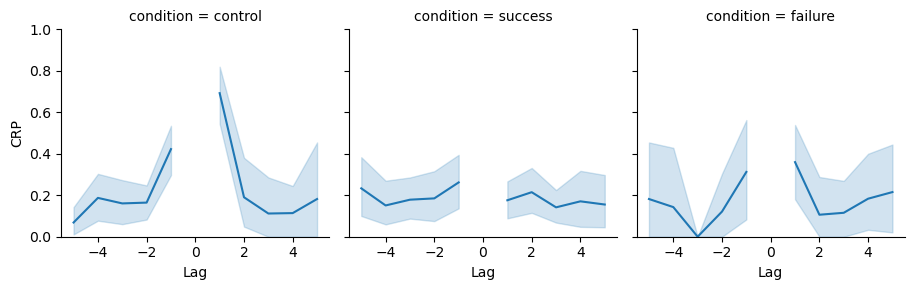

In [13]:
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [14]:
ranks_control = fr.lag_rank(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_success = fr.lag_rank(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_attempt = fr.lag_rank(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.733537
sem     0.028095
Name: rank, dtype: float64
success
mean    0.463882
sem     0.039428
Name: rank, dtype: float64
failure
mean    0.606753
sem     0.072369
Name: rank, dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/online_experiments/lib/python3.12/site-packages/psifr/measures.py:238: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/opt/homebrew/Caskroom/miniforge/base/envs/online_experiments/lib/python3.12/site-packages/psifr/measures.py:238: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/opt/homebrew/Caskroom/miniforge/base/envs/online_experiments/lib/python3.12/site-packages/psifr/measures.py:238: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/opt/homebrew/Caskroom/miniforge/base/envs/online_experiments/lib/python3.12/site-packages/psifr/measures.py:238: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.682292
1,1,0.559722
2,2,0.607857
3,3,0.750000
4,4,0.776852
5,5,0.211640
6,6,0.409524
7,7,0.704167
8,8,0.364815
9,9,0.359921


## Focusing on Transitions from Mid-Sequence Items

,subject,lag,prob,actual,possible,condition
0,0,-11,NaN,0,0,control
1,0,-10,NaN,0,0,control
2,0,-9,NaN,0,0,control
3,0,-8,NaN,0,0,control
4,0,-7,1.0,1,1,control
...,...,...,...,...,...,...
478,22,7,0.0,0,1,failure
479,22,8,0.5,1,2,failure
480,22,9,NaN,0,0,failure
481,22,10,NaN,0,0,failure


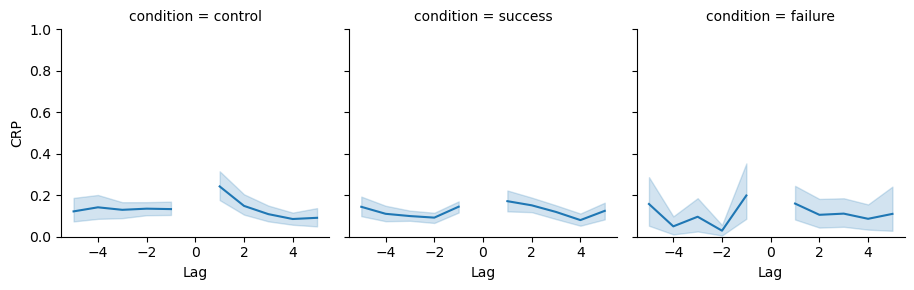

In [15]:
# %% From Mid-List Transition Lag-CRP
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])
# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [16]:
# %% From-Mid-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.527027
sem     0.017210
Name: rank, dtype: float64
success
mean    0.513287
sem     0.022427
Name: rank, dtype: float64
failure
mean    0.510202
sem     0.042253
Name: rank, dtype: float64


,subject,rank
0,0,0.651061
1,1,0.360998
2,2,0.631542
3,3,0.760795
4,4,0.639623
5,5,0.467551
6,6,0.534462
7,7,0.549093
8,8,0.431845
9,9,0.429836


In [17]:
# %% Comparison: From-Early-Or-Late-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.660444
sem     0.017180
Name: rank, dtype: float64
success
mean    0.639589
sem     0.020229
Name: rank, dtype: float64
failure
mean    0.620977
sem     0.031731
Name: rank, dtype: float64


,subject,rank
0,0,0.673801
1,1,0.597132
2,2,0.682116
3,3,0.790274
4,4,0.735853
5,5,0.641904
6,6,0.527897
7,7,0.650439
8,8,0.662335
9,9,0.524224
